In [2]:
import pandas as pd
import requests
import json
from pyjstat import pyjstat  

## Først et lite sports-api
* [https://api-sports.io/](https://api-sports.io/)
* Lag gratis konto eller logg in med google

In [3]:
api_key = "31d5cf4a12d29e845d6b08db3ede0685" #Din api-nøkkel

headers = {"x-apisports-key": api_key}

base_url = "https://v3.football.api-sports.io/"

response = requests.get(f"{base_url}/leagues", headers=headers)
response.status_code


200

In [11]:
data =response.json()
data["response"] # vanskelig å få oversikt

with open("ligaer.json", "w") as file:
    json.dump(data, file)


for liga in data["response"]:
    if liga["country"]["name"] == "Norway":
        if liga["league"]["name"] == "Eliteserien":
            liga_id = liga["league"]["id"]
liga_id
    

103

In [14]:
parameters = {"league": liga_id, "season": 2022}
response = requests.get(f"{base_url}/teams", headers=headers, params=parameters)
response.status_code

200

In [17]:
lag_data = response.json()

for lag in lag_data["response"]:
    
    if lag["team"]["name"] == "Aalesund":
        lag_id = lag["team"]["id"]
        
lag_id


757

In [18]:
parameters = {"season": 2022, "league": liga_id, "team": lag_id}
response = requests.get(f"{base_url}/teams/statistics", headers=headers, params = parameters)
response.status_code

200

<Axes: >

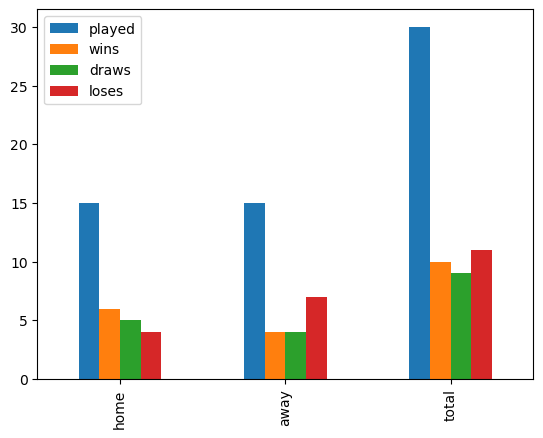

In [25]:
data_AAFK = response.json()

resultat = data_AAFK["response"]["fixtures"]
df = pd.DataFrame(data=resultat)
df
df.plot.bar()

# SSB sitt webAPI

* SSB har et eget webAPI slik at du automatisk kan hente inn nyeste data til:
  * Analyse
  * Visualisering
* Man kan få data på flere formater, vi anbefaler `json_stat`
  * Bruk `pyjstat` til å lese data inn i dataframe slik som fra eurostat

* Dersom man prøver å hente inn data fra feks tabell 09695 med et GET request får man tilbake meta-data om tabellen:
* [https://data.ssb.no/api/v0/no/table/09695](https://data.ssb.no/api/v0/no/table/09695)

In [27]:
konkurser_url ="https://data.ssb.no/api/v0/no/table/09695"
response = requests.get(konkurser_url)
metadata = response.json()
metadata

{'title': '09695: Opna konkursar, etter statistikkvariabel og måned',
 'variables': [{'code': 'ContentsCode',
   'text': 'statistikkvariabel',
   'values': ['Konkursar'],
   'valueTexts': ['Opna konkursar']},
  {'code': 'Tid',
   'text': 'måned',
   'values': ['1980M01',
    '1980M02',
    '1980M03',
    '1980M04',
    '1980M05',
    '1980M06',
    '1980M07',
    '1980M08',
    '1980M09',
    '1980M10',
    '1980M11',
    '1980M12',
    '1981M01',
    '1981M02',
    '1981M03',
    '1981M04',
    '1981M05',
    '1981M06',
    '1981M07',
    '1981M08',
    '1981M09',
    '1981M10',
    '1981M11',
    '1981M12',
    '1982M01',
    '1982M02',
    '1982M03',
    '1982M04',
    '1982M05',
    '1982M06',
    '1982M07',
    '1982M08',
    '1982M09',
    '1982M10',
    '1982M11',
    '1982M12',
    '1983M01',
    '1983M02',
    '1983M03',
    '1983M04',
    '1983M05',
    '1983M06',
    '1983M07',
    '1983M08',
    '1983M09',
    '1983M10',
    '1983M11',
    '1983M12',
    '1984M01',
    '198

* Det kan være nyttig å hente ut metadata og undersøke den
* Vi kan laste det inn i python og gjøre filtrering på hva vi vil ha med
* Vi kan kan også "klikke på linken" i en nettleser og se på verdiene der

## Sende spørring mot SSB sine dataset
* For å hente inn de faktiske dataene må vi sende en POST request til samme URL
* Denne post-requesten må inneholde egen data om spørringen vi gjør (Hvilke variabler vil vi ha + eventuelle filtreringer

![img/ssbapikonsoll.png](img/ssbapikonsoll.png)

* Det er ikke nødvendigvis plankekjøring å lage denne spørringen:
  * Vi kan bruke SSB sin [API-konsoll](https://data.ssb.no/api/v0/no/console) (bildet over)
  * I statistikkbanken kan vi undersøke og velge ut data, og nederst på siden kan vi hente spørringen for dataene vi har valgt

![spørring](img/lagresporring.png)

* Her kan vi klippe og lime teksten inn i python
* Eller lagre som fil og åpne i python med json.load("filnavn.json"):
```python
import json
with open("filnavn.json", "r") as file:
    ssb_query = json.load(file)
#
#
```

* SSB-spørringen inneholder et felt "query", som er en liste av "dictionaries" med variablene eller feltene fra tabellen vi vil hente
* Hvert dataobjekt vi spør etter har under "selection" et felt "filter" hvor vi angir hvilke av dataene vi vil ha

### SSB: Filter
* Vi kan velge "item", da spesifiserer vi alle verdiene:
  * `"filter": "item", "values": [«Liste med verdiene vi vil ha»]`
* Eller "top", da ber vi om feks de første 10 verdiene
  * `"filter": "top", "values": [«antall»]`
* Eller "all", da ber vi om alle som passer inn i et gitt "mønster"
  * `"filter": "all", "values": ["*"]` Alle resultat
  * `"filter": "all", "values": ["198*"]` Alle årstall fra 80-tallet ("*" matcher med 0,1,2,3...)

In [34]:
import requests
import json
import random

jsonstreng = """{ "query": [
    {"code": "ContentsCode","selection": {
        "filter": "item",
        "values": ["Konkursar"]
      }
    },
    {"code": "Tid", "selection": {
        "filter": "all",
        "values": []
      }
    }
  ],"response": {"format": "json-stat2"}
}"""
ssb_query = json.loads(jsonstreng)
ssb_query

#Ta med måned med 50% sannsynlighet
tid_hamed = []
for tid in metadata["variables"][1]["values"]:
    if random.random() < 0.5:
        tid_hamed.append(tid)
        
ssb_query["query"][1]["selection"]["filter"] = "item"
ssb_query["query"][1]["selection"]["values"] = tid_hamed

ssb_query

response = requests.post("https://data.ssb.no/api/v0/no/table/09695", json=ssb_query)
response.json()


{'version': '2.0',
 'class': 'dataset',
 'label': '09695: Opna konkursar, etter statistikkvariabel og måned',
 'source': 'Statistisk sentralbyrå',
 'updated': '2024-10-24T06:00:00Z',
 'role': {'time': ['Tid'], 'metric': ['ContentsCode']},
 'id': ['ContentsCode', 'Tid'],
 'size': [1, 260],
 'dimension': {'ContentsCode': {'label': 'statistikkvariabel',
   'category': {'index': {'Konkursar': 0},
    'label': {'Konkursar': 'Opna konkursar'},
    'unit': {'Konkursar': {'base': 'konkursar', 'decimals': 0}}},
   'extension': {'elimination': False,
    'refperiod': {'Konkursar': 'Månad'},
    'show': 'value'}},
  'Tid': {'label': 'måned',
   'category': {'index': {'1980M02': 0,
     '1980M05': 1,
     '1981M01': 2,
     '1981M06': 3,
     '1981M10': 4,
     '1981M12': 5,
     '1982M01': 6,
     '1982M02': 7,
     '1982M04': 8,
     '1982M05': 9,
     '1982M06': 10,
     '1982M07': 11,
     '1982M08': 12,
     '1982M10': 13,
     '1982M12': 14,
     '1983M03': 15,
     '1983M10': 16,
     '1983

In [ ]:
#Spørring etter åpna konkurser på 80-tallet
ssb_query_string = """
{
  "query": [
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Konkursar"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "all",
        "values": ["198*"]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}
"""

In [ ]:
#Spørring etter åpna konkurser de 15 siste månedene
ssb_query_string = """
{
  "query": [
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Konkursar"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "top",
        "values": ["15"]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}
"""

# Eksempel: SSB-spørring->Pandas dataframe via pyjstat

In [37]:
# Gå inn i api-konsoll eller statistikkbanken og lag en spørring og last ned spørringen som json fil
with open("opnakonk.json", "r") as file:
    ssb_query_data = json.load(file)


tabellnr = ssb_query_data["tableIdForQuery"]
url_konk = ssb_query_data["postUrl"]
ssb_query = ssb_query_data["queryObj"]

response = requests.post(url_konk, json=ssb_query)

#Lese inn json_stat med pyjstat
dataset = pyjstat.Dataset.read(response.text)
df = dataset.write("dataframe")
df_id = dataset.write("dataframe", naming="id")

{'version': '2.0',
 'class': 'dataset',
 'label': '09694: Opna konkursar, etter statistikkvariabel og år',
 'source': 'Statistisk sentralbyrå',
 'updated': '2024-01-26T07:00:00Z',
 'role': {'time': ['Tid'], 'metric': ['ContentsCode']},
 'id': ['ContentsCode', 'Tid'],
 'size': [1, 44],
 'dimension': {'ContentsCode': {'label': 'statistikkvariabel',
   'category': {'index': {'Konkursar': 0},
    'label': {'Konkursar': 'Opna konkursar'},
    'unit': {'Konkursar': {'base': 'konkursar', 'decimals': 0}}},
   'extension': {'elimination': False,
    'refperiod': {'Konkursar': '01.01.-31.12.'},
    'show': 'value'}},
  'Tid': {'label': 'år',
   'category': {'index': {'1980': 0,
     '1981': 1,
     '1982': 2,
     '1983': 3,
     '1984': 4,
     '1985': 5,
     '1986': 6,
     '1987': 7,
     '1988': 8,
     '1989': 9,
     '1990': 10,
     '1991': 11,
     '1992': 12,
     '1993': 13,
     '1994': 14,
     '1995': 15,
     '1996': 16,
     '1997': 17,
     '1998': 18,
     '1999': 19,
     '200

<Axes: xlabel='år'>

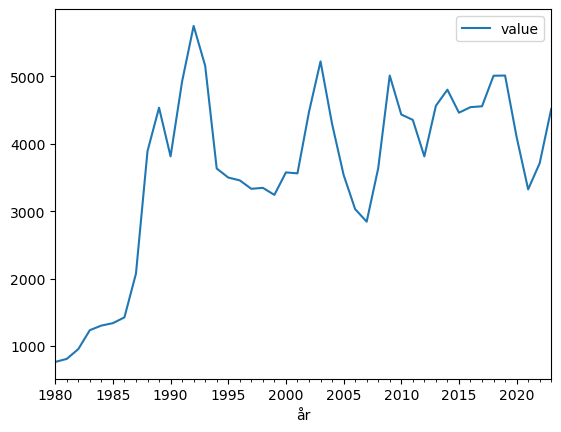

In [53]:


df["år"] = pd.to_datetime(df["år"], format="%Y")
df["år"] = df["år"].dt.to_period(freq="Y")
df.set_index("år").plot()